# **Requirements**


In [917]:
# Author: Muhammad Fathur Rizky
# Description: This notebook is used for Playground EP01

In [918]:
# !pip install xgboost catboost lightgbm scikit-learn
# !pip install optuna
# !pip install seaborn
# !pip install shap
# !pip uninstall -y scikit-learn
# !pip install scikit-learn==1.5.2

In [919]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
    VotingClassifier,
    HistGradientBoostingClassifier
)
from sklearn.linear_model import LogisticRegression

import shap

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

In [920]:
settings = {
    "LABEL": "reservation_status",
    "SEED": 42,
    "TRAIN_PATH": r"data-community-hmif-playground-ep-01\train.csv",
    "TEST_PATH": r"data-community-hmif-playground-ep-01\test.csv",
    "SUBMISSION_PATH": r"data-community-hmif-playground-ep-01\sample_submission.csv"
}


def set_seed(seed: int) -> None:
    np.random.seed(seed)

In [921]:
train = pd.read_csv(settings['TRAIN_PATH'], index_col=0)
train.head()
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75636 entries, 0 to 75635
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           75636 non-null  object 
 1   lead_time                       75636 non-null  int64  
 2   arrival_date_year               75636 non-null  int64  
 3   arrival_date_month              75636 non-null  object 
 4   arrival_date_week_number        75636 non-null  int64  
 5   arrival_date_day_of_month       75636 non-null  int64  
 6   stays_in_weekend_nights         75636 non-null  int64  
 7   stays_in_week_nights            75636 non-null  int64  
 8   adults                          75636 non-null  int64  
 9   children                        75633 non-null  float64
 10  babies                          75636 non-null  int64  
 11  meal                            75636 non-null  object 
 12  country                         75311

# **EDA**


In [922]:
display(train.select_dtypes(include='object').describe())
display(train.select_dtypes(exclude='object').describe())

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type
count,75636,75636,75636,75311,75636,75636,75636,75636,75636,75636
unique,2,12,5,164,8,5,10,11,3,4
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient
freq,50262,8729,58566,30643,35794,62055,54353,46802,66304,56740


,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,reservation_status
count,75636.000000,75636.000000,75636.000000,75636.000000,75636.000000,75636.000000,75636.000000,75633.000000,75636.000000,75636.000000,75636.000000,75636.000000,75636.000000,65369.000000,4287.000000,75636.000000,75636.000000,75636.000000,75636.000000
mean,104.216841,2016.158351,27.191509,15.782921,0.929531,2.506650,1.856946,0.103764,0.007563,0.031361,0.086348,0.139999,0.221046,86.723172,189.899697,2.316146,101.932624,0.062602,0.636046
std,106.797344,0.706349,13.618039,8.770960,1.002940,1.923848,0.564948,0.396923,0.093249,0.174292,0.838637,1.525138,0.648692,110.755189,132.540272,17.523782,51.928827,0.245124,0.481139
min,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.000000,0.000000,0.000000
50%,70.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,95.000000,0.000000,1.000000
75%,161.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,274.000000,0.000000,126.000000,0.000000,1.000000
max,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,3.000000,9.000000,1.000000,26.000000,72.000000,20.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,1.000000


In [923]:
def unique_values(df: pd.DataFrame) -> None:
    for column in df.select_dtypes(include='object').columns:
        print(f"{column}: {df[column].unique()}")


unique_values(train)

hotel: ['Resort Hotel' 'City Hotel']
arrival_date_month: ['March' 'December' 'August' 'May' 'April' 'July' 'June' 'September'
 'February' 'October' 'January' 'November']
meal: ['HB' 'BB' 'Undefined' 'SC' 'FB']
country: ['PRT' 'FRA' 'IRL' 'ESP' 'DEU' 'GBR' 'ISR' 'ROU' 'BEL' 'SWE' 'NLD' 'BRA'
 'AUT' 'ITA' 'CN' 'LVA' 'POL' 'USA' 'CHE' 'TUR' nan 'IRN' 'KWT' 'GRC'
 'NOR' 'LUX' 'DNK' 'QAT' 'ZMB' 'EST' 'FIN' 'AUS' 'RUS' 'GTM' 'EGY' 'MAR'
 'HRV' 'NZL' 'CHN' 'ARG' 'KOR' 'ARE' 'BIH' 'AGO' 'JPN' 'THA' 'ZAF' 'SRB'
 'PER' 'LAO' 'MOZ' 'GUY' 'AIA' 'CZE' 'KAZ' 'SVK' 'IND' 'DZA' 'CHL' 'MKD'
 'HUN' 'COL' 'AND' 'ISL' 'ECU' 'LBY' 'ETH' 'MDV' 'NGA' 'SVN' 'CUB' 'PLW'
 'PAN' 'ARM' 'LTU' 'BEN' 'GEO' 'ZWE' 'TUN' 'MLT' 'CYP' 'HKG' 'TWN' 'PHL'
 'KNA' 'MAC' 'JAM' 'MEX' 'SGP' 'CRI' 'JEY' 'BGR' 'MYS' 'AZE' 'UKR' 'SAU'
 'KHM' 'BHR' 'TMP' 'BLR' 'SEN' 'URY' 'GIB' 'IRQ' 'PRI' 'CMR' 'DOM' 'CPV'
 'VEN' 'GGY' 'MWI' 'VGB' 'PAK' 'IDN' 'OMN' 'ALB' 'GNB' 'CAF' 'BOL' 'MCO'
 'KEN' 'BHS' 'BGD' 'VNM' 'LBN' 'GHA' 'TJK' 'NCL' 'TZA'

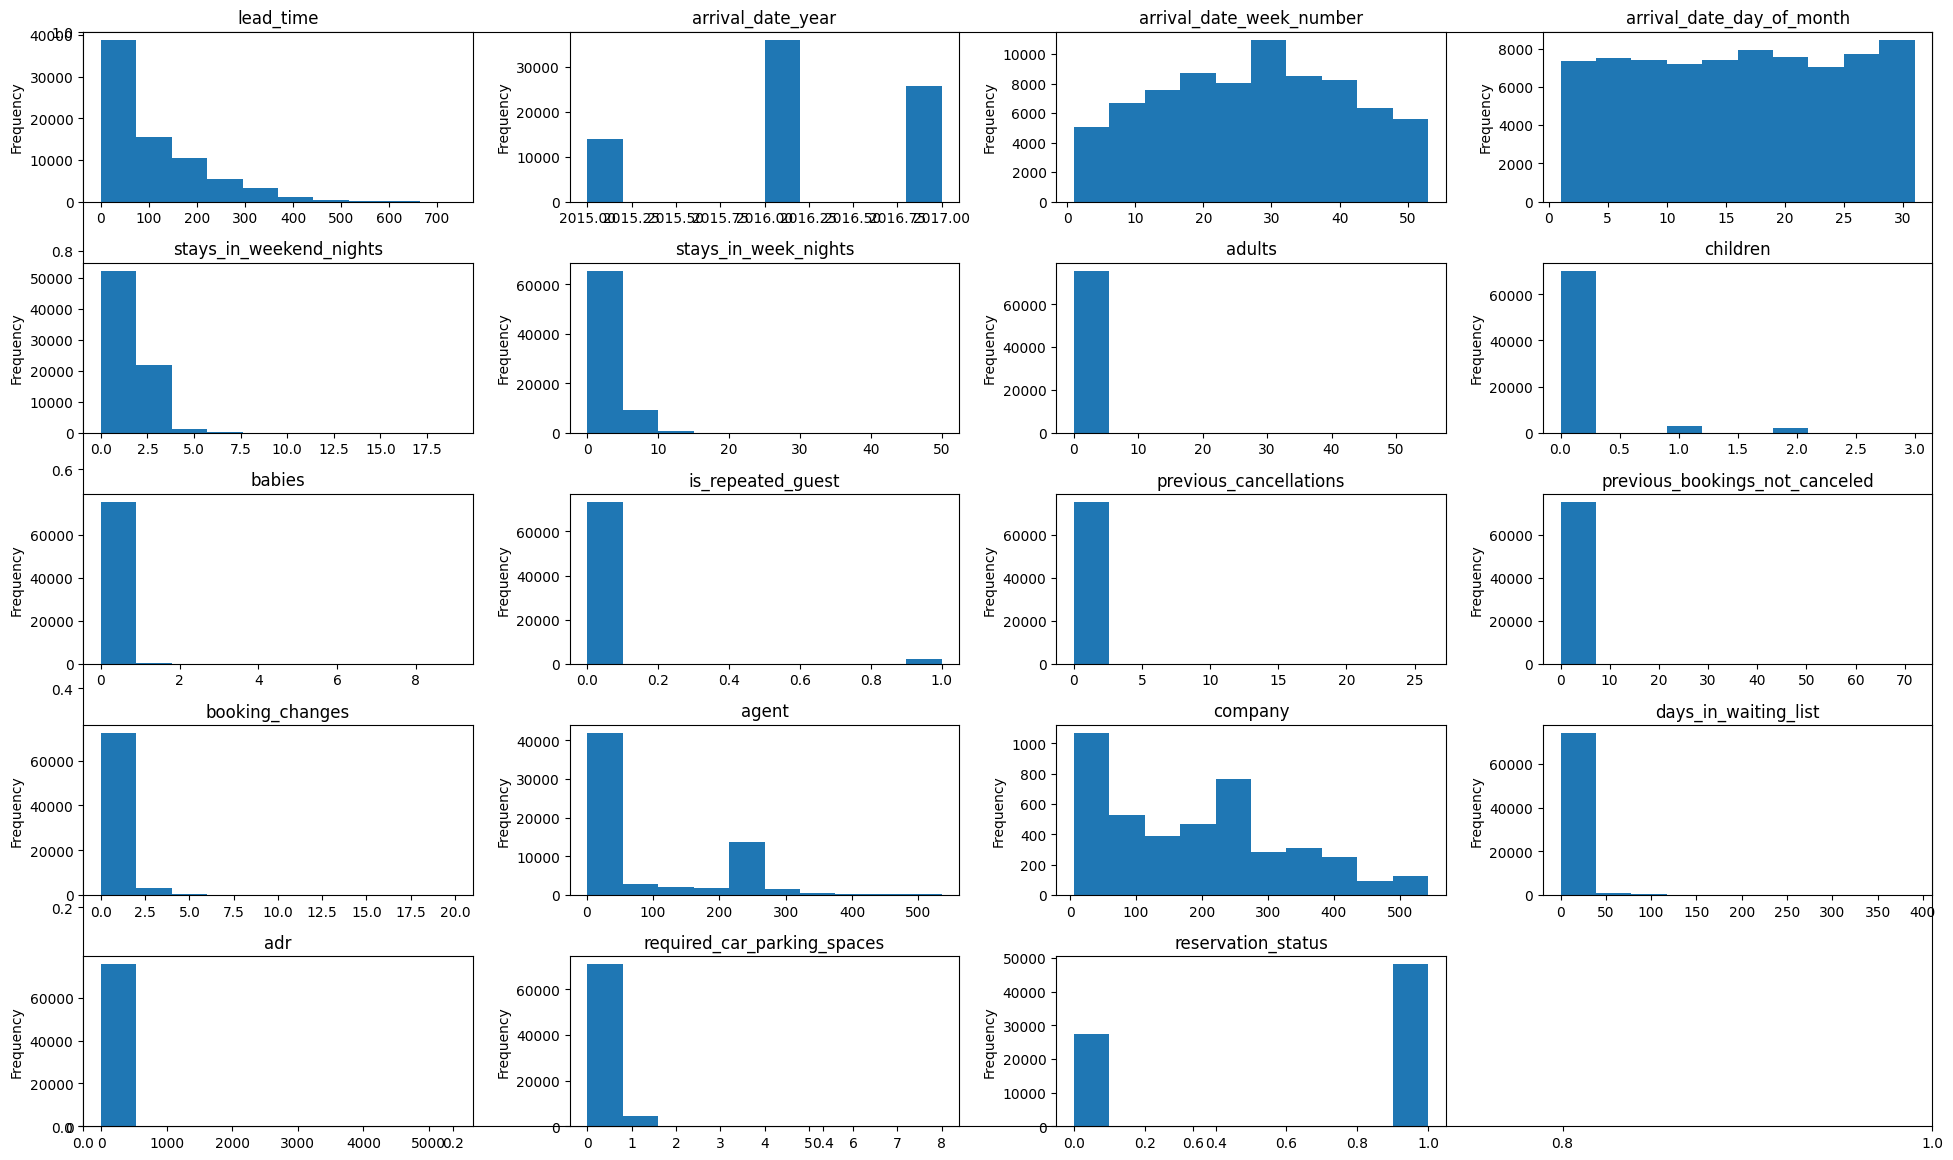

In [924]:
def plot_distribution(df: pd.DataFrame) -> None:
    fig, ax = plt.subplots(figsize=(20, 12))
    for i, column in enumerate(df.select_dtypes(include='object').columns):
        plt.subplot(3, 4, i+1)
        df[column].value_counts().plot(kind='bar')
        plt.xticks(rotation=45)
        plt.xlabel(None)
        plt.title(column)
    plt.tight_layout()
    plt.show()


def plot_histogram(df: pd.DataFrame) -> None:
    fig, ax = plt.subplots(figsize=(20, 12))
    for i, column in enumerate(df.select_dtypes(exclude='object').columns):
        plt.subplot(5, 4, i+1)
        df[column].plot(kind='hist')
        plt.xlabel(None)
        plt.title(column)
    plt.tight_layout()
    plt.show()


# plot_distribution(train)
plot_histogram(train)

In [925]:
# corr_matrix = train.select_dtypes(include='number').corr()
# plt.figure(figsize=(16, 12))
# sns.heatmap(corr_matrix, annot=True, fmt=".2f")
# # plt.show()

# **Preprocessing**


In [926]:
import pandas as pd

class Preprocessing:
    def __init__(self):
        self.columns = None 
        self.target = None

    def feature_creation(self, df: pd.DataFrame) -> pd.DataFrame:
        return df.copy()

    def feature_encoding(self, df: pd.DataFrame, fit=False) -> pd.DataFrame:
        df = pd.get_dummies(df, drop_first=True, dtype=float)

        if fit:
            self.columns = df.columns 
        else:
            missing_cols = set(self.columns) - set(df.columns)
            extra_cols = set(df.columns) - set(self.columns)

            for col in missing_cols:
                df[col] = 0

            # Drop extra columns
            df = df.drop(columns=extra_cols, errors="ignore")

            # Reorder columns to match training set
            df = df[self.columns]

        return df

    def change_data_type(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        if "arrival_date_year" in df.columns:
            df["arrival_date_year"] = df["arrival_date_year"].astype("category")
        return df

    def feature_dropping(self, df: pd.DataFrame) -> pd.DataFrame:
        return df.drop(["company"], axis=1, errors="ignore")

    def fit(self, df: pd.DataFrame) -> pd.DataFrame:
        df = self.feature_dropping(df)
        df = self.feature_encoding(df, fit=True)
        return df

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        df = self.feature_creation(df)
        df = self.feature_dropping(df)
        df = self.feature_encoding(df, fit=False)
        df = self.change_data_type(df)
        return df

    def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        return self.transform(self.fit(df))


In [927]:
preprocessor = Preprocessing()
train, y = train.drop(settings['LABEL'], axis=1), train[settings['LABEL']]
train = preprocessor.fit(train)
train = preprocessor.transform(train)

train.head()

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
id,,,,,,,,,,,,,,,,,,,,,
0,312,2017,10,5,2,5,2,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,2015,51,18,0,2,2,1.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,41,2016,14,31,0,3,2,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,228,2016,36,29,2,5,2,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,128,2017,19,13,0,1,3,0.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# **Modeling**


In [928]:
# from sklearn.utils.class_weight import compute_sample_weight
# sample_weight = compute_sample_weight(
#     class_weight='balanced', y=train[settings['LABEL']])
# print(sample_weight)

In [929]:
rf_params = {
    "random_state": settings["SEED"],
    "n_estimators": 1000,
    "n_jobs": -1,
}

xgb_params = {
    'verbose': -1,
    'random_state': settings["SEED"],
    'enable_categorical': True,
    'max_depth': 11, 'learning_rate': 0.027543508673161333, 'colsample_bytree': 0.6749001638998652, 'reg_lambda': 0.07374835907527036, 'reg_alpha': 1.1214778945448294, 'gamma': 0.027742570057383103,
    "use_label_encoder": False,
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "n_estimators": 10000,
    "tree_method": "hist",
    "device": "cuda",
}

cat_params = {
    'verbose': 0,
    'random_state': settings["SEED"],
    'cat_features': train.select_dtypes(include='category').columns.tolist(),
    'task_type': 'GPU',
    'n_estimators': 2000,
}

lgbm_params = {
    'verbose': -1,
    'random_state': settings["SEED"],
    'enable_categorical': True,
    # 'class_weight': 'balanced',
    'learning_rate': 0.1,
    'max_depth': 11,
    'n_estimators': 10000,
}

et_params = {
    "random_state": settings["SEED"],
    'n_estimators': 1000,
}

gb_params = {
    "random_state": settings["SEED"],
}

hgb_params = {
    'max_iter': 10000,
    'categorical_features': train.select_dtypes(include='category').columns.tolist(),
    'random_state': settings["SEED"],
}

In [930]:
# stacking =

models = {
    # "RandomForest": RandomForestClassifier(**rf_params),
    # "GradientBoosting": GradientBoostingClassifier(**gb_params),
    # "XGBoost": XGBClassifier(**xgb_params),
    # "CatBoost": CatBoostClassifier(**cat_params),
    # "HistGradientBoosting": HistGradientBoostingClassifier(**hgb_params),
    # "LightGBM": LGBMClassifier(**lgbm_params),
    # "Stacking": StackingClassifier(estimators=[
    #     # ('RandomForest', RandomForestClassifier(**rf_params)),
    #     # ('ExtraTrees', ExtraTreesClassifier(**et_params)),
    #     # ('GradientBoosting', GradientBoostingClassifier(**gb_params)),
    #     # ('LogisticRegression', LogisticRegression(**lr_params)),
    #     # ('XGBoost', XGBClassifier(**xgb_params)),
    #     # ('CatBoost', CatBoostClassifier(**cat_params)),
    #     ('LightGBM', LGBMClassifier(**lgbm_params)),
    # ], final_estimator=LGBMClassifier(**lgbm_params)),
    "Voting": VotingClassifier(estimators=[
        ('HistGradientBoosting', HistGradientBoostingClassifier(**hgb_params)),
        ('XGBoost', XGBClassifier(**xgb_params)),
        ('RandomForest', RandomForestClassifier(**rf_params)),
        ('LightGBM', LGBMClassifier(**lgbm_params)),
    ], voting='hard', n_jobs=-1),
}

In [931]:
# import optuna
# X_train = train.drop(columns=[settings['LABEL']])
# y_train = train[settings['LABEL']]
# # Define the Optuna objective function
# def objective(trial):
#     params = {
#         "n_estimators": 1000,
#         "max_depth": trial.suggest_int("max_depth", 9, 15),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.0001, 0.4),
#         # "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
#         "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
#         "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
#         "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
#         "gamma": trial.suggest_loguniform("gamma", 1e-3, 10.0),
#         # "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
#         "random_state": 42,
#         "use_label_encoder": False,
#         "objective": "binary:logistic",  # Change to "multi:softmax" if multi-class
#         "eval_metric": "logloss",
#         "enable_categorical": True,
#         "verbose": 0,
#     }

#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     acc_scores = []

#     for train_index, test_index in skf.split(X_train, y_train):
#         X_tr, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
#         y_tr, y_val = y_train.iloc[train_index], y_train.iloc[test_index]

#         # Train XGBoost model
#         model = XGBClassifier(**params)
#         model.fit(X_tr, y_tr)

#         y_pred = model.predict(X_val)
#         acc_scores.append(accuracy_score(y_val, y_pred))

#     # Return mean accuracy across folds
#     return np.mean(acc_scores)
# # Create Optuna study
# study = optuna.create_study(direction="maximize")  # Maximize accuracy
# study.optimize(objective, n_trials=100)

# # Best hyperparameters
# print("Best Hyperparameters:", study.best_params)
# print("Best Accuracy:", study.best_value)

In [932]:
import shap
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

skf = StratifiedKFold(n_splits=5, random_state=settings["SEED"], shuffle=True)

for name, model in models.items():
    print(f"{name}")
    acc_scores = []
    f1_scores = []

    explainer = None

    for fold, (train_index, test_index) in enumerate(skf.split(train, y)):
        X_train, X_test = train.iloc[train_index], train.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # model = XGBClassifier(**xgb_params)
        model.fit(X_train, y_train)

        if False:
            explainer = shap.Explainer(model, X_train)

            shap_values = explainer(X_test)

            # shap.plots.beeswarm(shap_values)

            shap_df = pd.DataFrame({
                "feature": X_train.columns,
                # Mean absolute SHAP values
                "shap_importance": np.abs(shap_values.values).mean(axis=0)
            })
            shap_df = shap_df.sort_values(
                by="shap_importance", ascending=False)
            shap_df = shap_df.tail(10)
            print(shap_df['feature'].values)
            display(shap_df)

        y_pred = model.predict(X_test)
        acc_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

        print(f"Fold-{fold} Accuracy: {accuracy_score(y_test, y_pred)}")

    # Print overall results
    print(f"Accuracy: {np.mean(acc_scores)} ± {np.std(acc_scores)}")
    print(f"F1 Score: {np.mean(f1_scores)} ± {np.std(f1_scores)}")

Voting
Fold-0 Accuracy: 0.8785695399259651
Fold-1 Accuracy: 0.8725457790705361
Fold-2 Accuracy: 0.8805447213591591
Fold-3 Accuracy: 0.8792886890989621
Fold-4 Accuracy: 0.8804125074370331
Accuracy: 0.8782722473783311 ± 0.002954956074899046
F1 Score: 0.8782969237650944 ± 0.002958885466709418


# **Final Submission**


In [933]:
sample = pd.read_csv(
    r'data-community-hmif-playground-ep-01\sample_submission.csv', index_col=0)
train = pd.read_csv(
    r'data-community-hmif-playground-ep-01\train.csv', index_col=0)
test = pd.read_csv(
    r'data-community-hmif-playground-ep-01\test.csv', index_col=0)

train, y = train.drop(settings["LABEL"], axis=1), train[settings["LABEL"]]
preprocessor = Preprocessing()
train = preprocessor.fit_transform(train)
test = preprocessor.transform(test)

model = models["Voting"]
model.fit(train, y)

sample[settings["LABEL"]] = model.predict(test)
sample.to_csv("submission_hard.csv")

In [934]:
train.shape, test.shape

((75636, 231), (18910, 231))